In [4]:
# Making non-stationary time series stationary
import cpi
import pandas as pd
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import yfinance as yf
import matplotlib.pyplot as plt

In [5]:
df = yf.download('GC=F', start = '2000-01-01',
                end='2020-01-01',
                progress=True)
df.rename(columns = {'Close': 'price'}, inplace = True)
df = df.resample('M').last()
df = df[['price']]

[*********************100%***********************]  1 of 1 completed


In [6]:
cpi.update()

In [7]:
# Define a function for running the ADF test

def adf_test(x):
    indices = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag = 'AIC')
    results = pd.Series(adf_test[:4], index = indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    return results
        

In [8]:
# run the test

adf_test(df)
# the null hypothesis : ts is not stationary
# p-values is more then Critical Value (1%) that's why we fail to reject the null hypothesis 

Test Statistic             -1.245430
p-value                     0.653754
# of Lags Used             11.000000
# of Observations Used    221.000000
Critical Value (1%)        -3.460291
Critical Value (5%)        -2.874709
Critical Value (10%)       -2.573789
dtype: float64

In [9]:
# since the test statistic  > critical value 1% we conclude that ts is not stationary

def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression = h0_type)
    
    results = pd.Series(kpss_test[:3], index = indices)
    print()
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    return results
        
    

In [10]:
kpss_test(df)
# the null hypothesis : ts is stationary
# p-values is less then Critical Value (1%) that's why we reject the null hypothesis 

/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic            1.253341
p-value                   0.010000
# of Lags                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

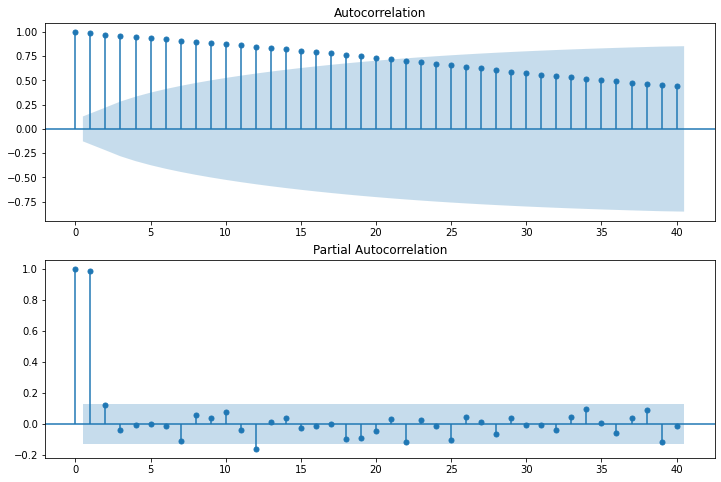

In [11]:
# Generate the ACF/PACF plots

N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1, figsize = (12, 8))
plot_acf(df.price, ax = ax[0], lags = N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.price, ax= ax[1], lags = N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plt.show()

# STATIONARITY AUTOCORRECTION

In [41]:
import cpi
import pandas as pd
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np

In [52]:
def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type = h0_type)
    
    print('ADF test statisti {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'], 
                                                              adf_results['p-value']))
    print('KPSS test statistic {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              adf_results['p-value']))
    fig, ax = plt.subplots(2, figsize = (16, 8))
    
    plot_acf(x, ax = ax[0], lags = n_lags, alpha = alpha)
    plot_pacf(x, ax = ax[1], lags = n_lags, alpha=alpha)
    
    
    return fig

In [37]:
# deflate the gold prices and plot the results


DEFL_DATE = date(2019, 12, 31)

df['dt_index'] = df.index.map(lambda x: x.to_pydatetime().date())
df['price_deflated'] = df.apply(lambda x: cpi.inflate(x.price, x.dt_index, DEFL_DATE), axis = 1)

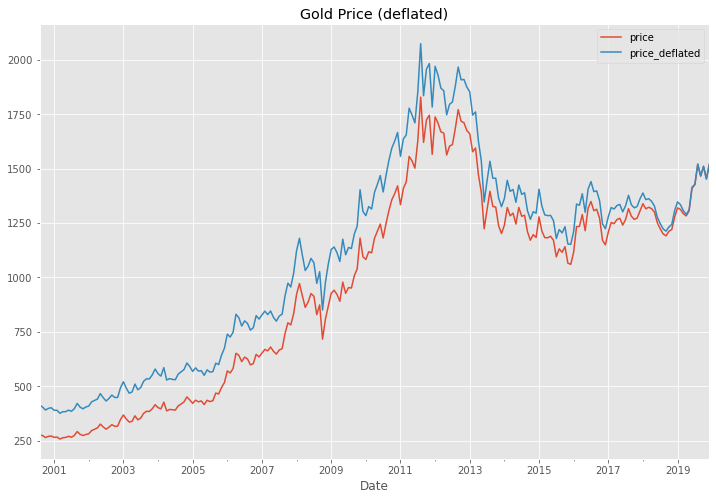

In [38]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (12, 8))
df[['price', 'price_deflated']].plot(ax = ax, title='Gold Price (deflated)')
plt.show()

In [39]:
# deflate the series using a natural logarithm

In [47]:

WINDOW = 12

selected_columns = ['price_log', 'rolling_mean_log', 'rolling_std_log']

df['price_log'] = np.log(df.price_deflated)
df['rolling_mean_log'] = df.price_log.rolling(WINDOW).mean()
df['rolling_std_log'] = df.price_log.rolling(WINDOW).std()

df[selected_columns].plot(title = 'Gold price (logged)')

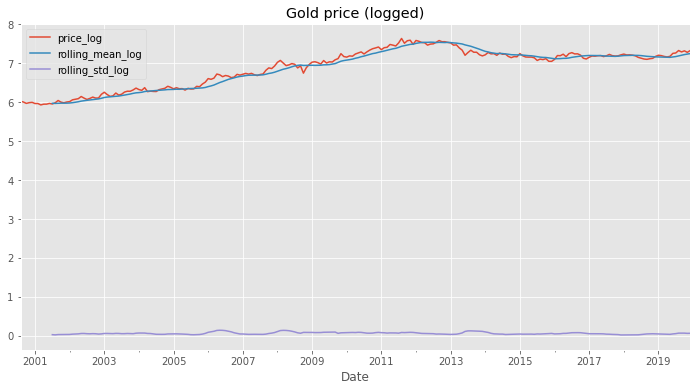

In [50]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (12, 6))
df[selected_columns].plot(title = 'Gold price (logged)', ax = ax)
plt.show()

log transformation made the exponential trend linear.


ADF test statisti -1.62 (p-val: 0.47)
KPSS test statistic 1.23 (p-val: 0.47)


/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


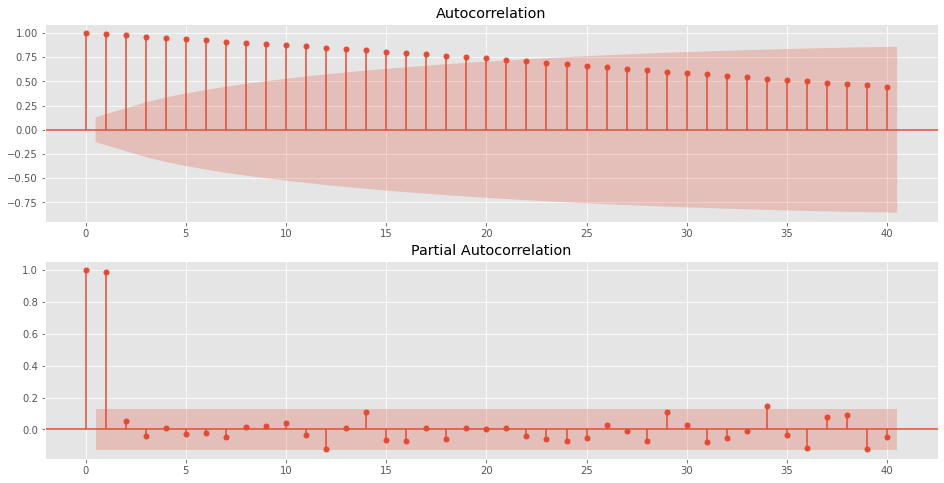

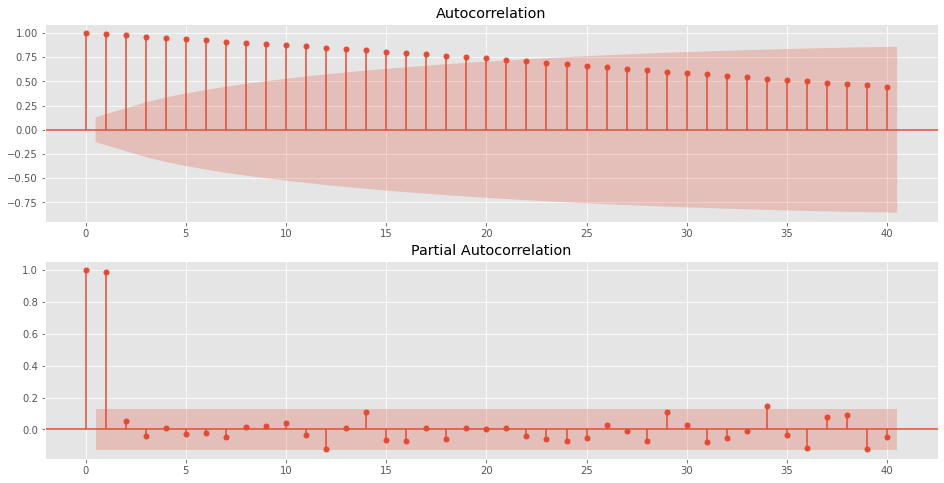

In [55]:
# test_autocorrelation function helps to investigate whether the series is stationary
test_autocorrelation(df.price_log)

In [ ]:
# ADF test statisti -1.62 (p-val: 0.47)
# KPSS test statistic 1.23 (p-val: 0.47)

# We can conclude that the log transformed ts is not stationary

In [60]:
# Apply differencing to TS and plot the results

selected_columns = ['price_log_diff','roll_mean_log_diff', 'roll_std_log_diff']

df['price_log_diff'] = df.price_log.diff(1)
df['roll_mean_log_diff'] = df.price_log_diff.rolling(WINDOW).mean()
df['roll_std_log_diff'] = df.price_log_diff.rolling(WINDOW).std()

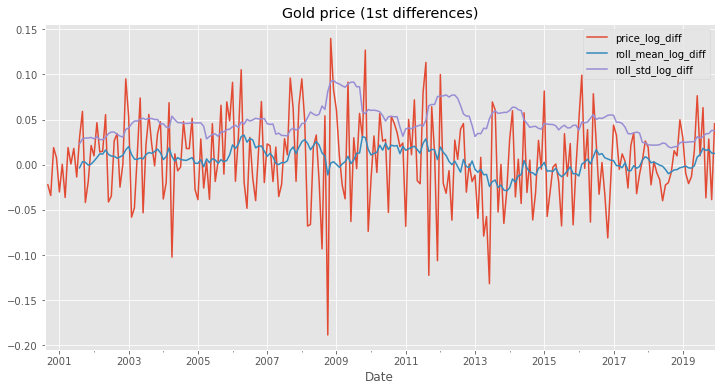

In [61]:
fig, ax = plt.subplots(figsize = (12, 6))
df[selected_columns].plot(title = 'Gold price (1st differences)', ax = ax)
plt.show()


ADF test statisti -17.22 (p-val: 0.00)
KPSS test statistic 0.29 (p-val: 0.00)


/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


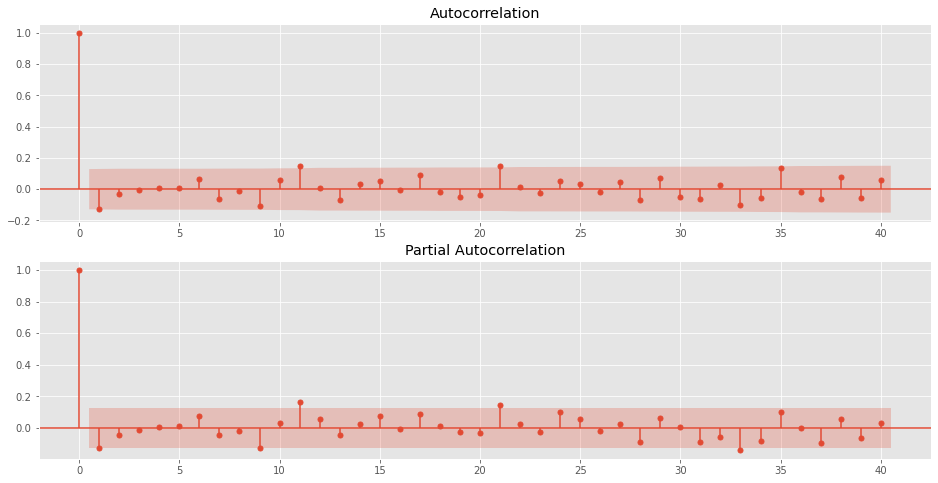

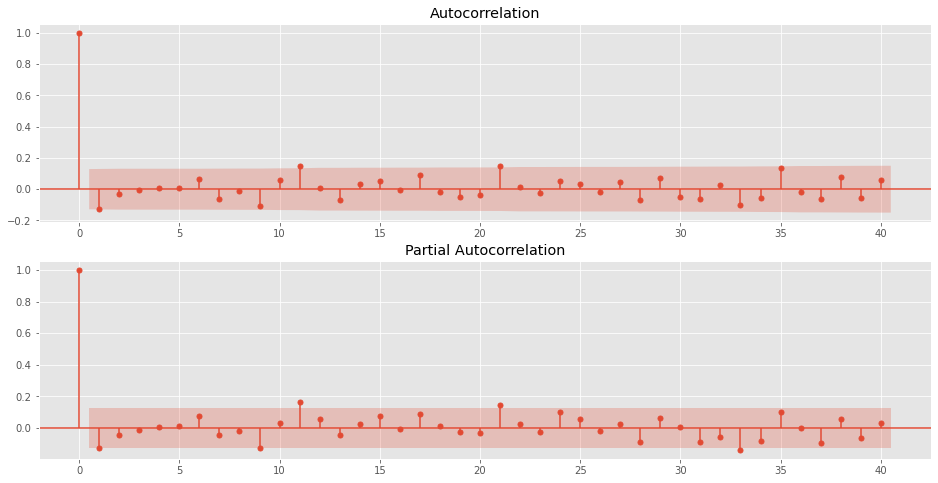

In [64]:
# test whether the series became stationary

test_autocorrelation(df.price_log_diff.dropna())

In [65]:
# ADF test statistic -17.22 (p-val: 0.00)
# KPSS test statistic 0.29 (p-val: 0.00)


# since ADF hypothesis is proved(non-stationary) and KPSS is rejected (stationary) 
# we conclude that TS became stationary